In [40]:
%pylab inline
from pylab import rcParams
from math import log
rcParams['figure.figsize'] = 16, 10
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from scipy import stats
from scipy.stats import norm, skew #for some statistics
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\Prog\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm', 'log', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [41]:
df = pd.read_csv('data/train.csv', index_col='Id')
ts = pd.read_csv('data/test.csv', index_col='Id')

In [42]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

# Global

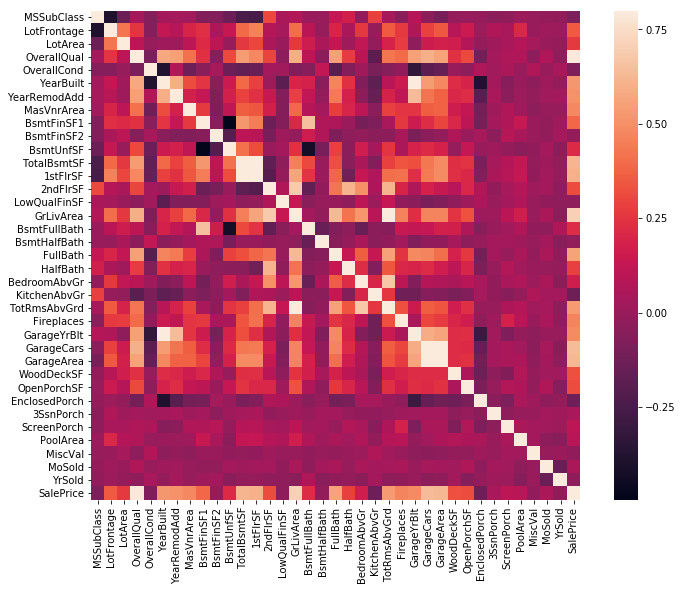

In [44]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# Sale Price

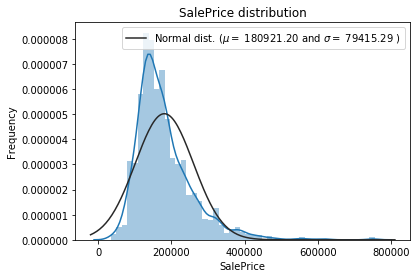

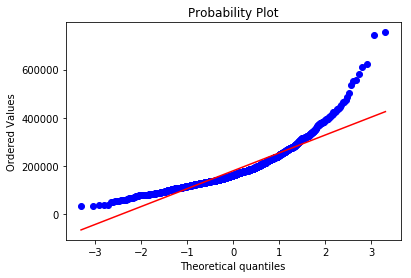

In [45]:
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

### Transform 

In [46]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["SalePrice"] = np.log1p(df["SalePrice"])

# Global 

In [47]:
ntrain = df.shape[0]
ntest = ts.shape[0]
y_train = df.SalePrice.values
all_data = pd.concat((df, ts)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


## Ground living area

In [48]:
df.GrLivArea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

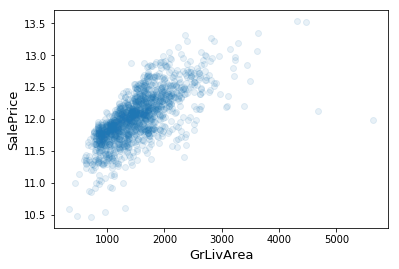

In [49]:
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'], alpha=0.1)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [50]:
#Deleting outliers
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

## Missing Data

In [51]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.sort_values(ascending=False)[:30]
all_data_cts = (all_data.isnull().sum())
all_data_cts = all_data_cts.sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na, 'Count': all_data_cts})
missing_data.head(20)

,Count,Missing Ratio
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071


Text(0.5,1,'Percent missing data by feature')

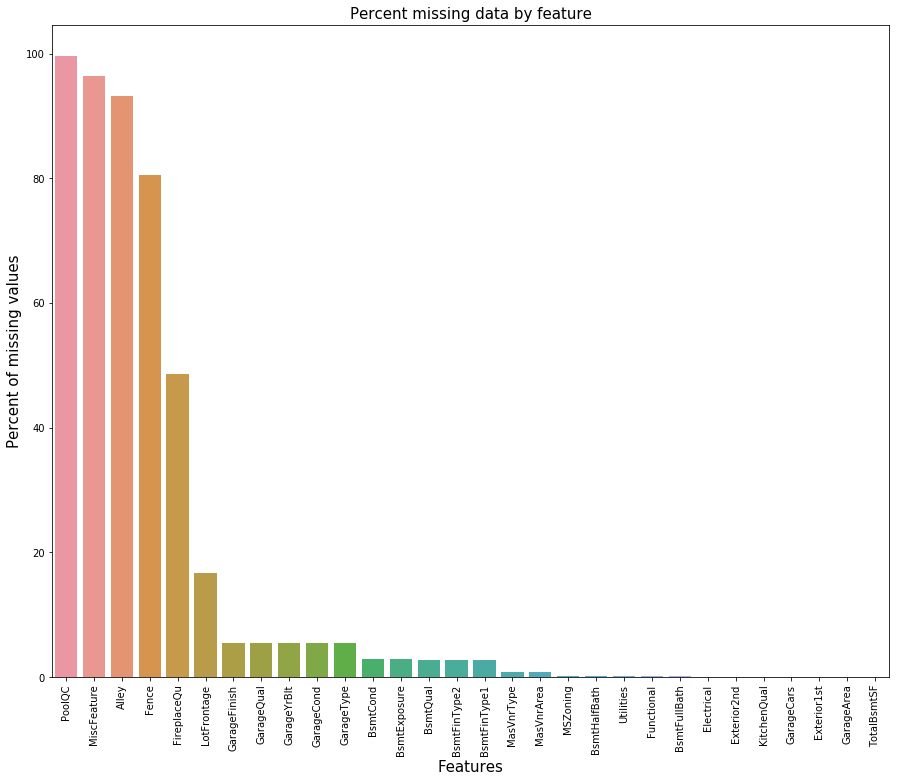

In [52]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [63]:
all_data.MiscFeature.value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [67]:
all_data.Neighborhood.value_counts()

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64

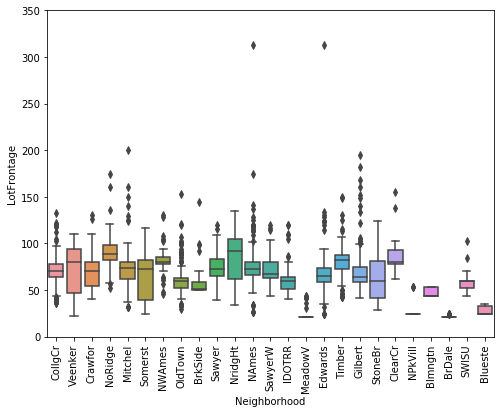

In [72]:
#box plot overallqual/saleprice
var = 'Neighborhood'
data = pd.concat([all_data['LotFrontage'], all_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="LotFrontage", data=data)
fig.axis(ymin=0, ymax=350);
plt.xticks(rotation=90);

## Imputing missing values

In [55]:
# Empty == None
all_data["PoolQC"] = all_data["PoolQC"].fillna("None") # NA == no swimming pool
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None") # None no mic features
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [ ]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# ???? use not Neighborhood but 1stFlrSurf
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [69]:
all_data.LotFrontage.describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64